In [13]:
import sys
import glob,os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
sys.path.append("../")
import utils.data_utils as du
import utils.visualization_utils as vu

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Init paths
raw_dir = os.environ.get("DES_DATA")
dump_dir = './dump/data_skimming/'
debug=False

In [4]:
# load complete data
# do run: process_Data_for_notebooks.py first! the notebook crashes with such large data to process
df= {} # only header
df_w_photo = {} # merged with photometry
for dtype in ["fake", "real"]:
    df_head_tmp = []
    df_head_w_phot_tmp = []
    bazin_file = f"{Path(raw_dir)}/DESALL_forcePhoto_{dtype}_snana_fits/DESALL_{dtype}_Bazin_fit.SNANA.TEXT"
    if Path(bazin_file).exists():
        df_bazin = du.load_bazin_fits(bazin_file)
        
    list_files = glob.glob(os.path.join(f"{raw_dir}/DESALL_forcePhoto_{dtype}_snana_fits/", "*PHOT.FITS"))
    for fname in list_files:
        dump_prefix = Path(fname).name.split("_")[0]

        df_header, df_phot = du.read_fits(fname)
        df_header = pd.merge(df_header, df_bazin, on='SNID')
        df_header = df_header[[
            k for k in df_header.keys() if 'Unnamed' not in k]]
        
        df_head_w_phot = df_header.merge(df_phot,on='SNID')
        
        df_head_tmp.append(df_header)
        df_head_w_phot_tmp.append(df_head_w_phot)
    df[dtype] = pd.concat(df_head_tmp)
    df_w_photo[dtype] = pd.concat(df_head_w_phot_tmp)

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



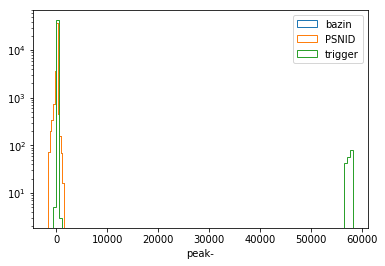

In [5]:
#sanity check for bazin
# only for fakes
fig = plt.figure()
plt.hist(df['fake']['PRIVATE(DES_fake_peakmjd)']-df['fake']["PKMJDINI"],histtype="step",label='bazin',bins=10)
plt.hist(df['fake']['PRIVATE(DES_fake_peakmjd)']-df['fake']["PEAKMJD"],histtype="step",label='PSNID')
plt.hist(df['fake']['PRIVATE(DES_fake_peakmjd)']-df['fake']["PRIVATE(DES_mjd_trigger)"],histtype="step",label='trigger',bins=100)
plt.xlabel('peak-')
plt.yscale("log")
plt.legend()

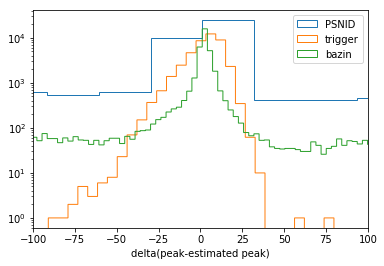

In [6]:
fig = plt.figure()
plt.hist(df['fake']['PRIVATE(DES_fake_peakmjd)']-df['fake']["PEAKMJD"],histtype="step",label='PSNID',bins=100)
plt.hist(df['fake']['PRIVATE(DES_fake_peakmjd)']-df['fake']["PRIVATE(DES_mjd_trigger)"],histtype="step",label='trigger',bins=10000)
plt.hist(df['fake']['PRIVATE(DES_fake_peakmjd)']-df['fake']["PKMJDINI"],histtype="step",label='bazin',bins=1000)
plt.xlabel('delta(peak-estimated peak)')
plt.yscale("log")
plt.xlim(-100,100)
plt.legend()

inspecting the ones that fail the windowing procedure

In [7]:
df['fake']['fakemjd'] = df['fake']['PRIVATE(DES_fake_peakmjd)']
df['fake']['trigger'] = df['fake']['PRIVATE(DES_mjd_trigger)']
df['fake']['delta_trigger'] = df['fake'].apply(
        lambda row: row.trigger - row.fakemjd, axis=1)
df['fake']['delta_bazin'] = df['fake'].apply(
        lambda row: row.PKMJDINI - row.fakemjd, axis=1)

In [8]:
# fail trigger
df_fail_trigger = df['fake'][abs(df['fake']['delta_trigger']) > 100]
# fail bazin
df_fail_bazin = df['fake'][abs(df['fake']['delta_bazin']) > 100]

In [9]:
# need to get photometry as well
df_wp_fail_trigger = df_w_photo['fake'][df_w_photo['fake'].SNID.isin(df_fail_trigger['SNID'].values)]
df_wp_fail_bazin = df_w_photo['fake'][df_w_photo['fake'].SNID.isin(df_fail_bazin['SNID'].values)]

[Plot light-curves] 


/Users/anaismoller/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[Plot light-curves] 


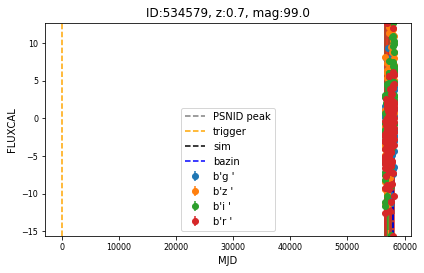

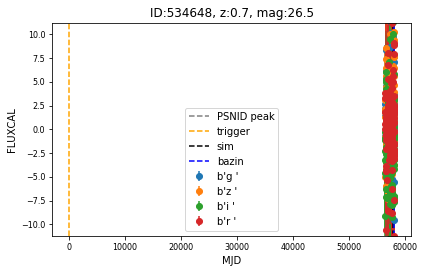

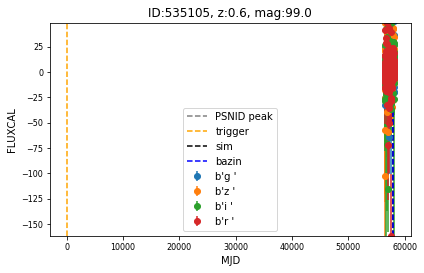

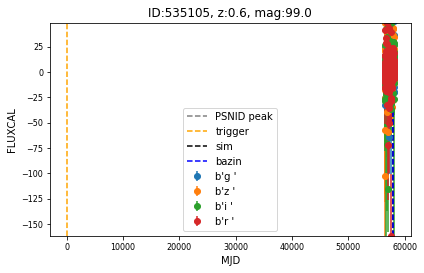

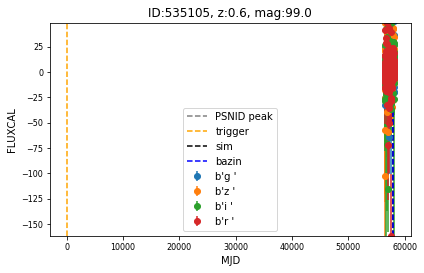

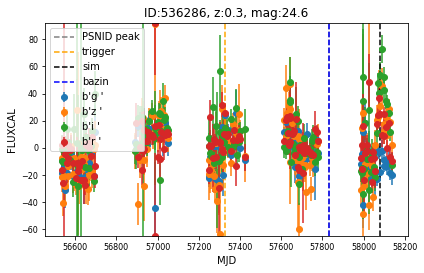

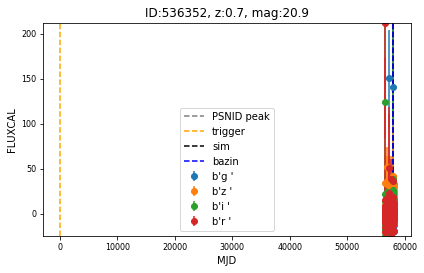

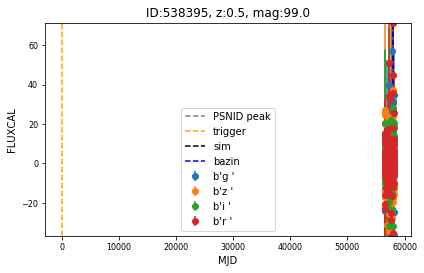

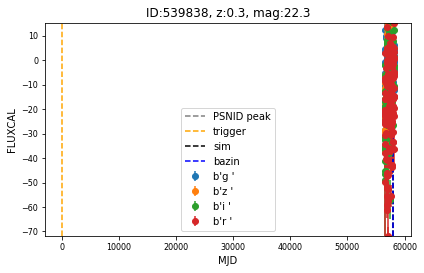

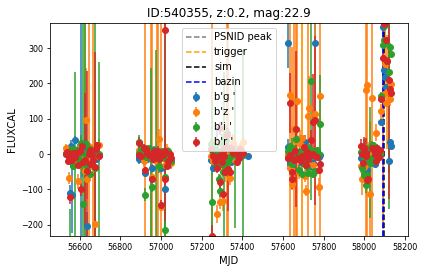

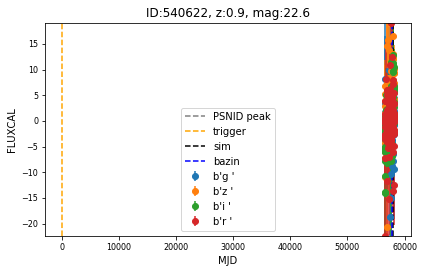

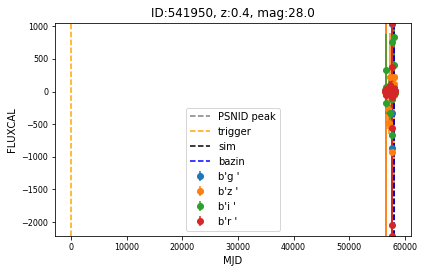

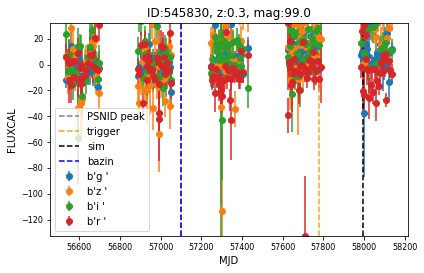

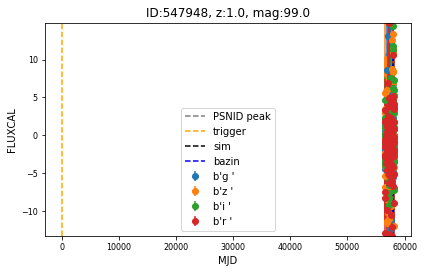

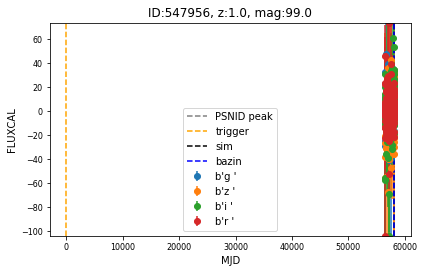

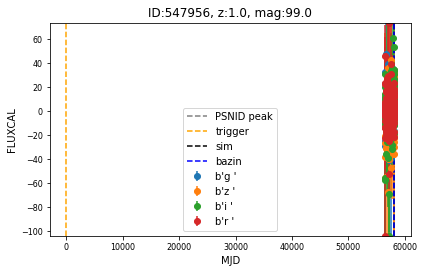

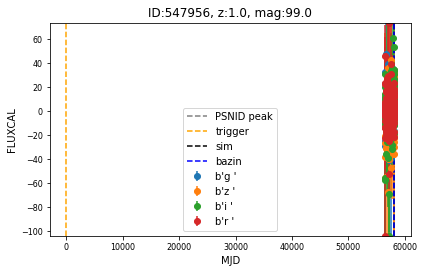

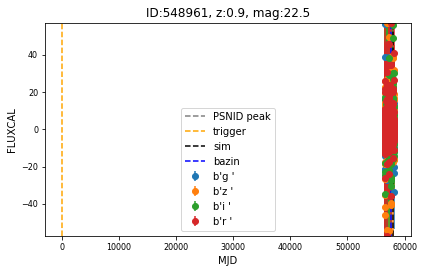

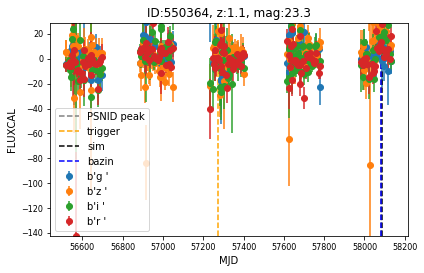

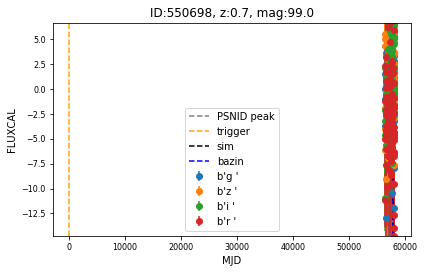

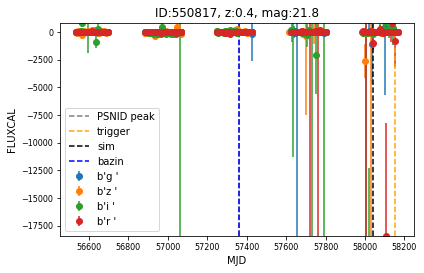

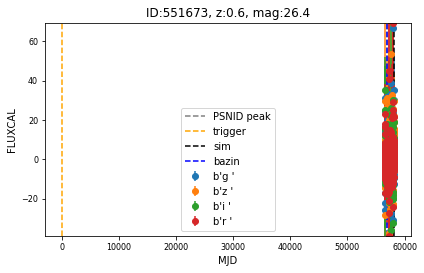

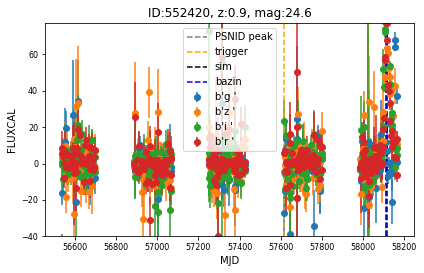

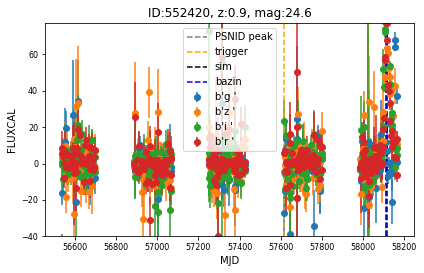

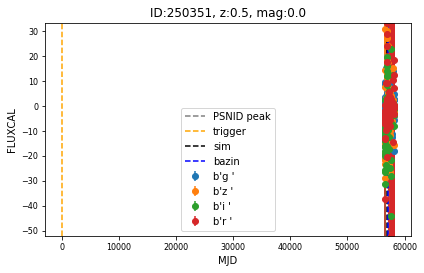

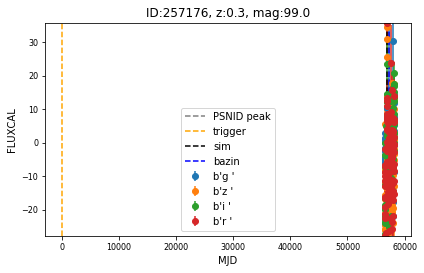

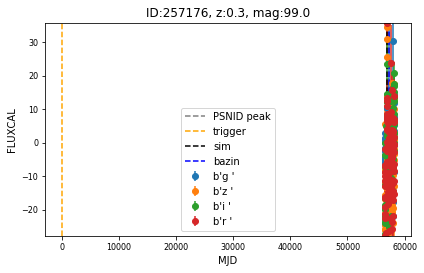

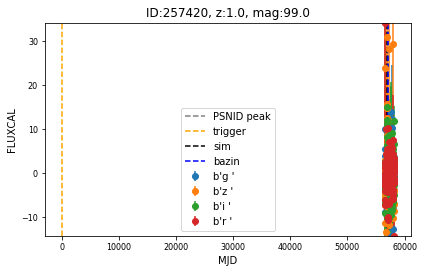

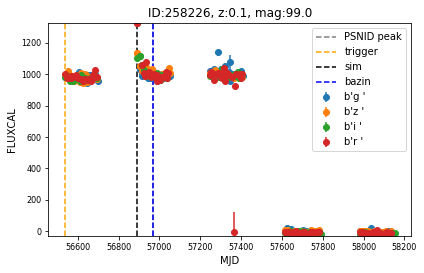

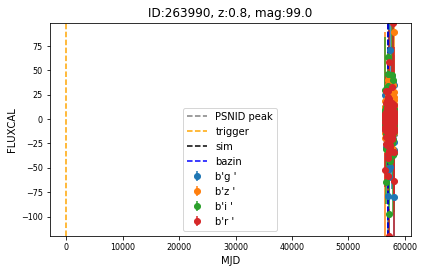

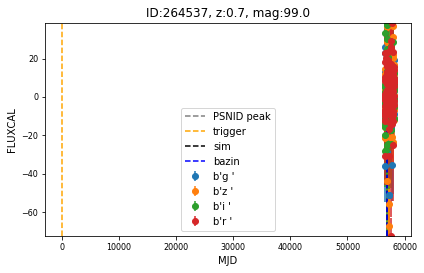

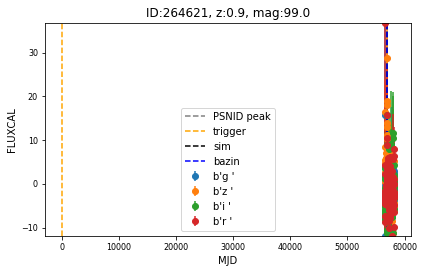

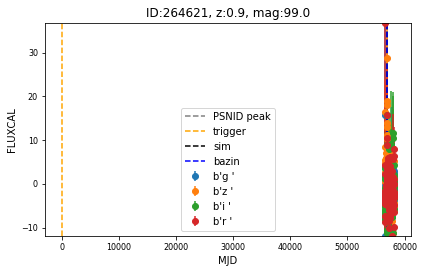

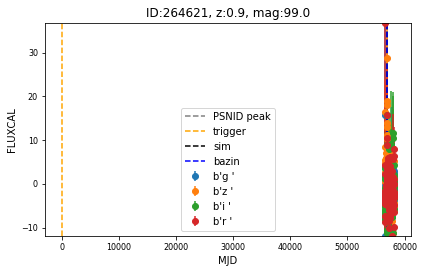

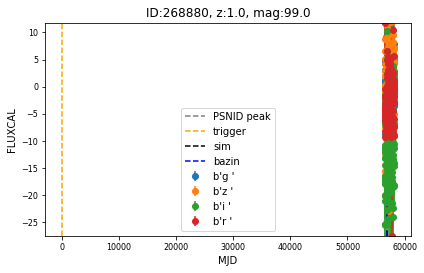

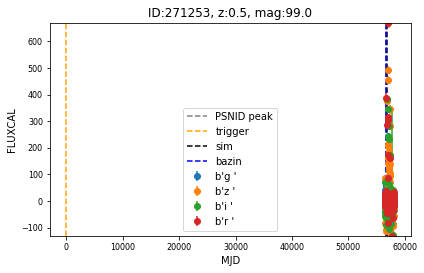

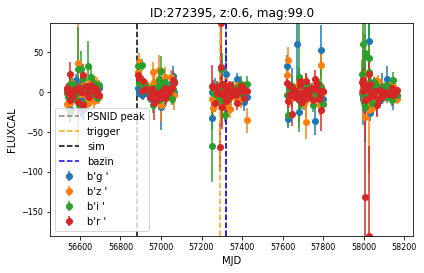

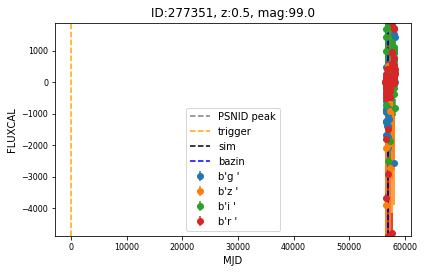

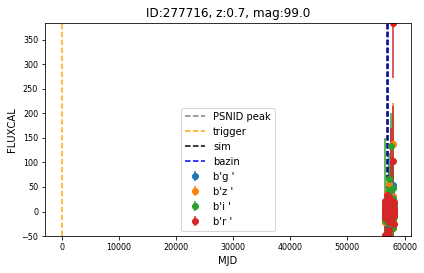

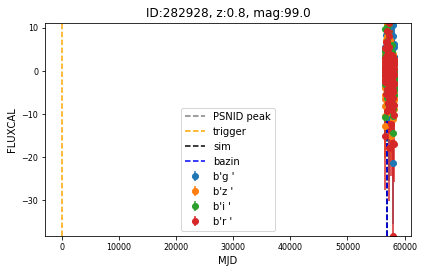

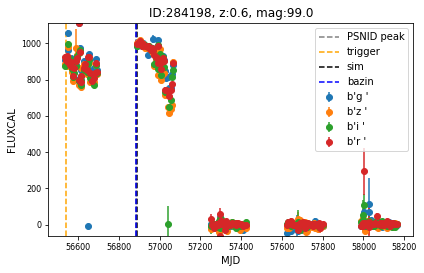

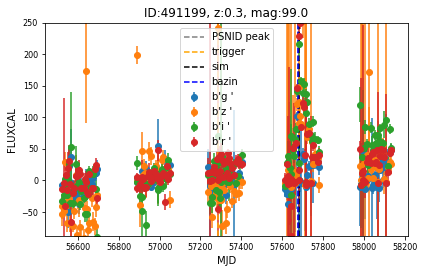

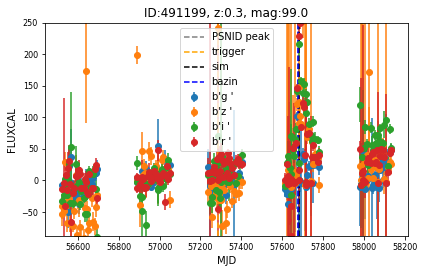

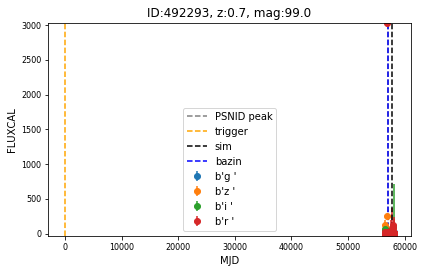

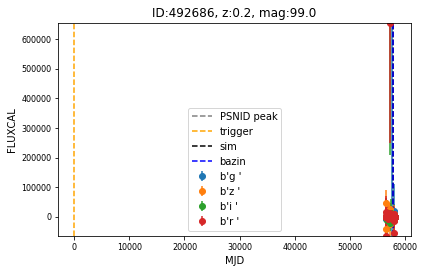

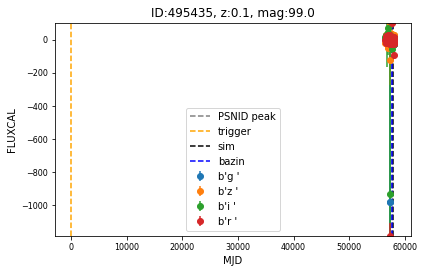

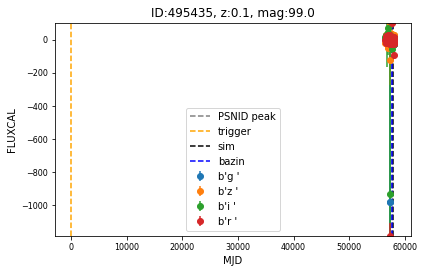

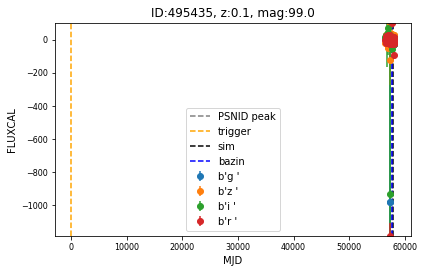

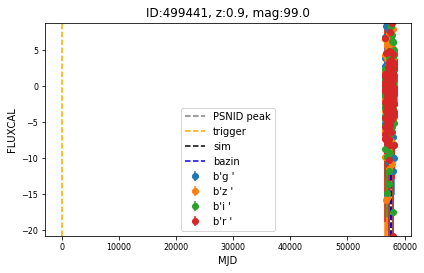

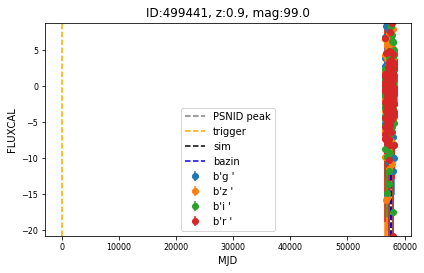

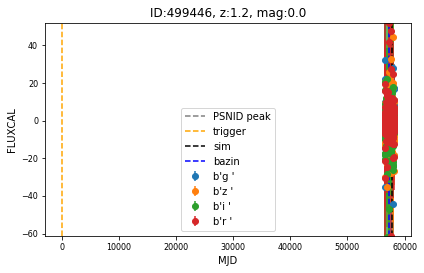

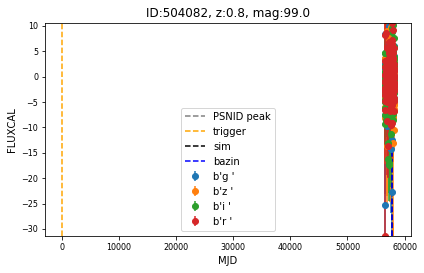

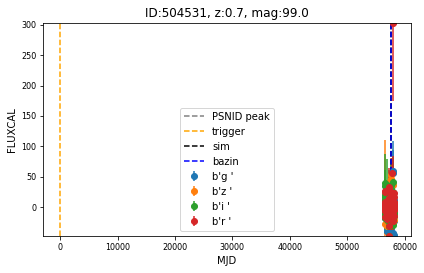

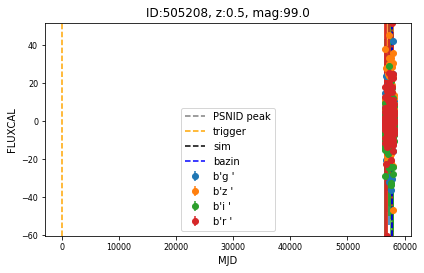

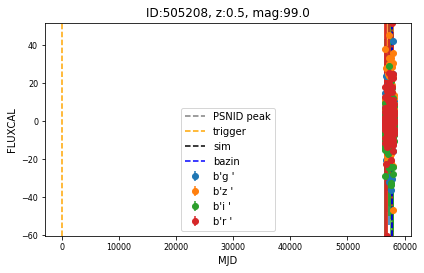

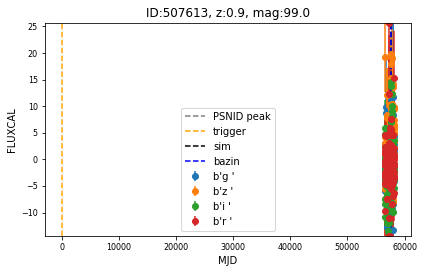

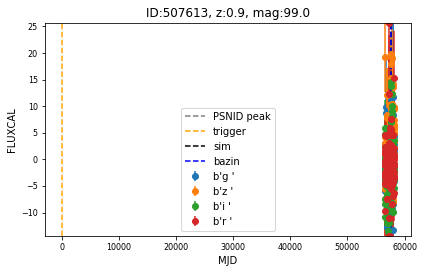

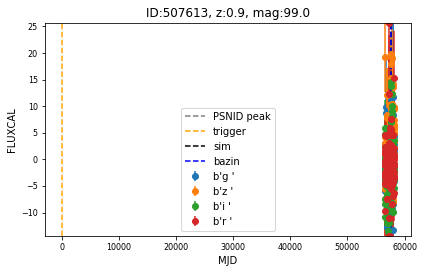

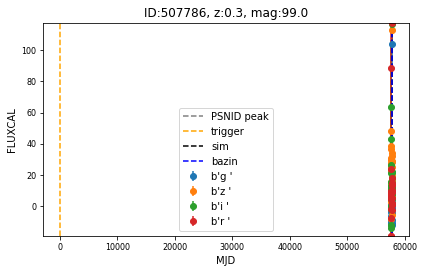

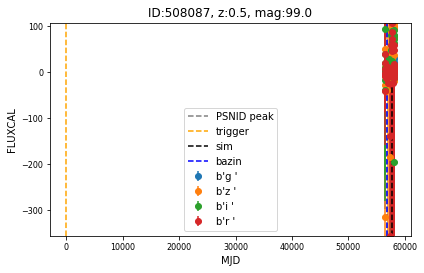

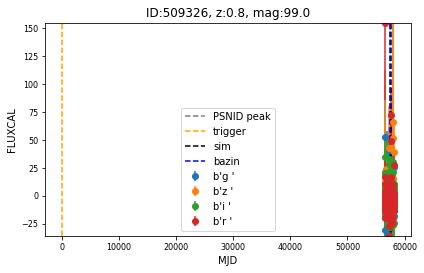

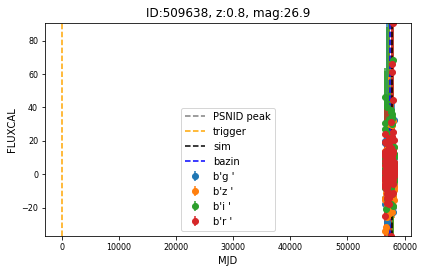

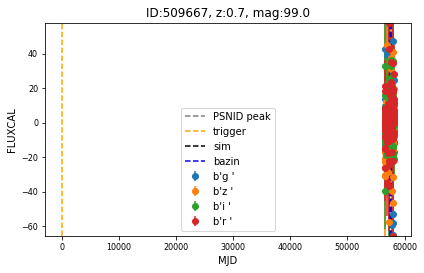

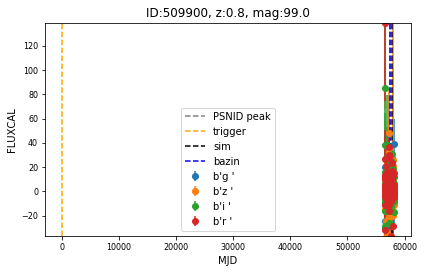

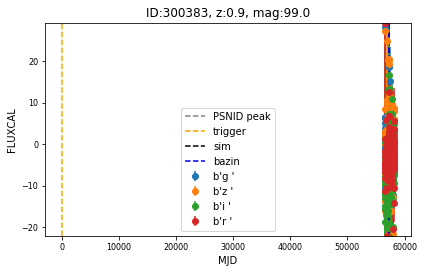

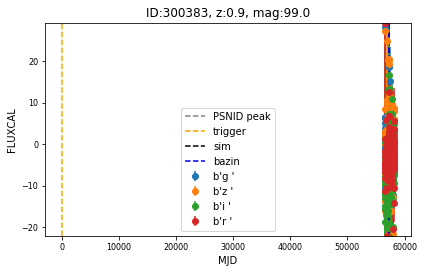

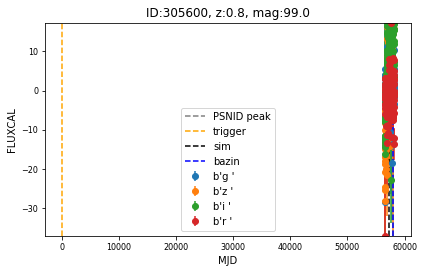

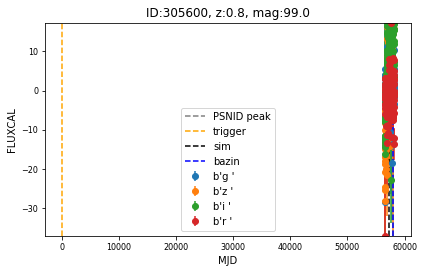

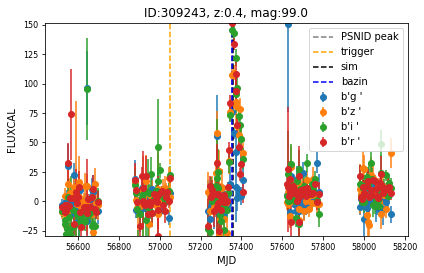

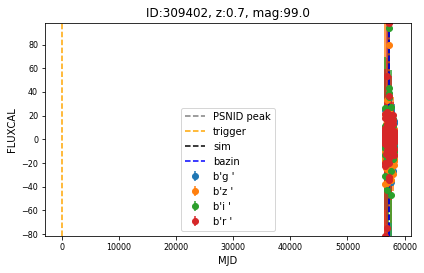

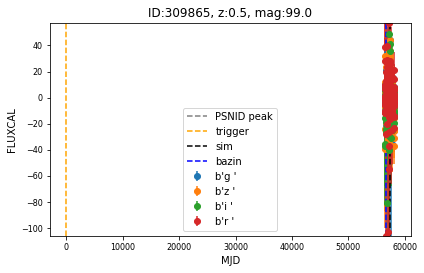

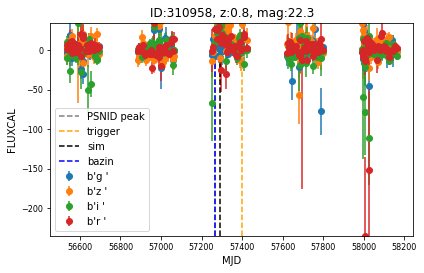

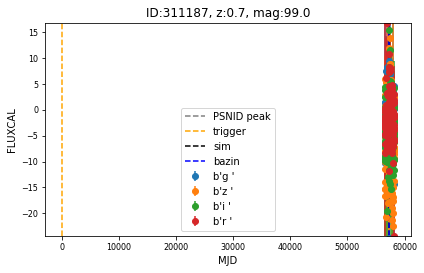

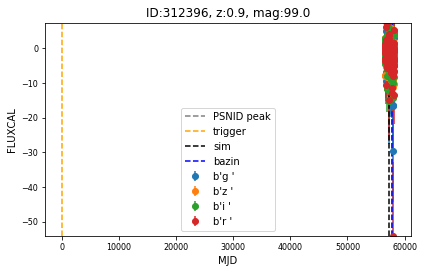

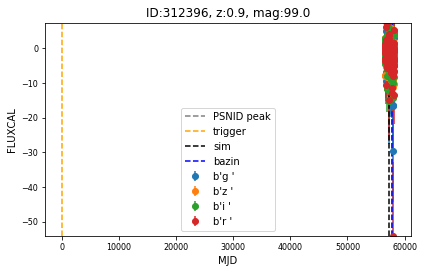

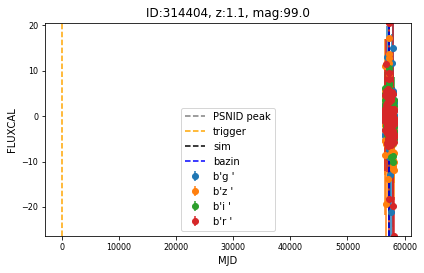

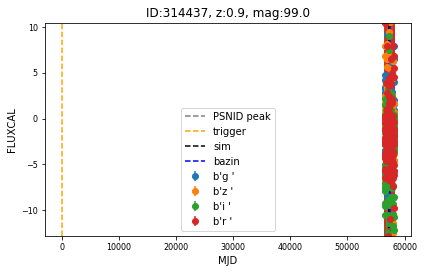

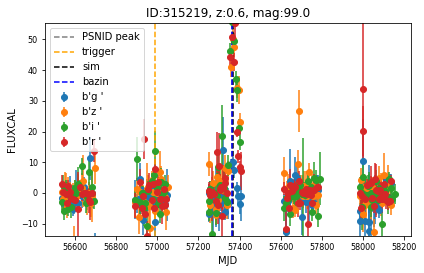

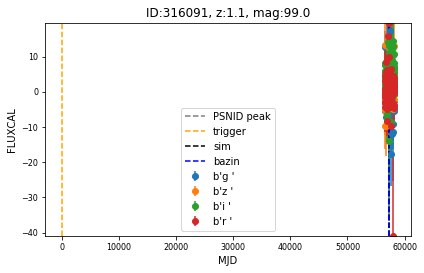

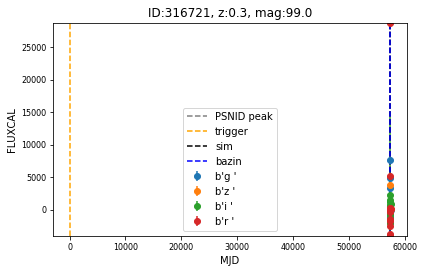

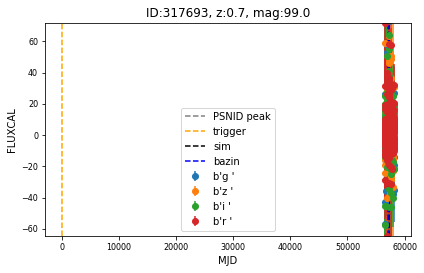

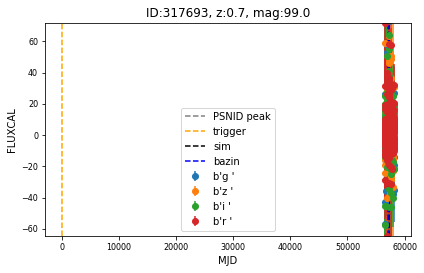

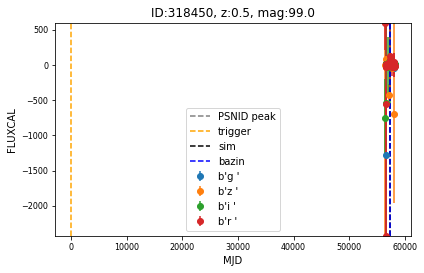

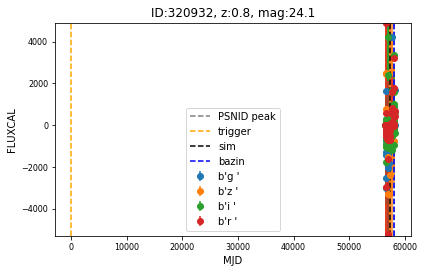

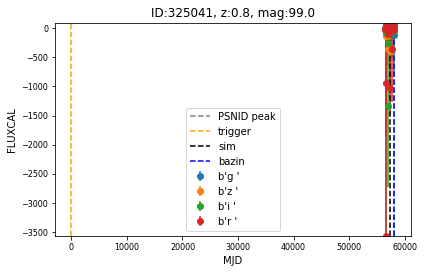

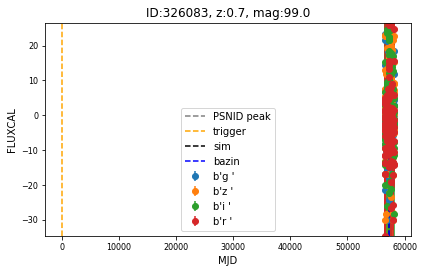

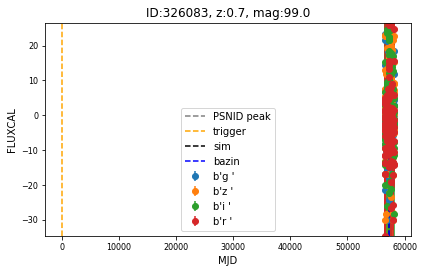

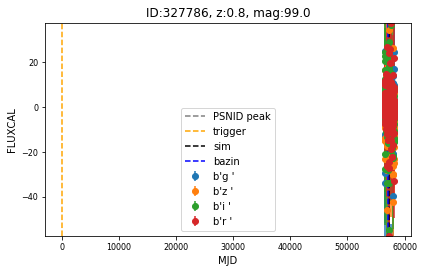

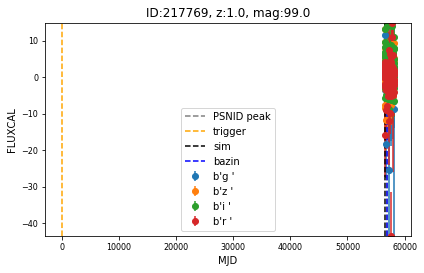

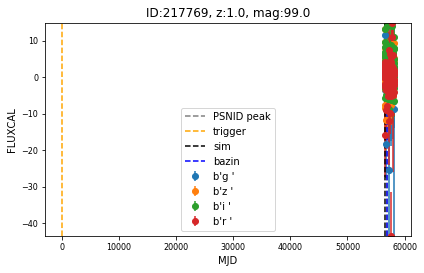

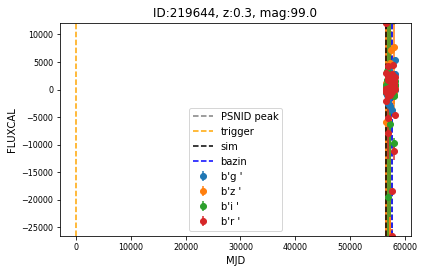

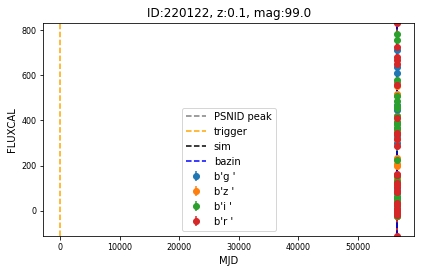

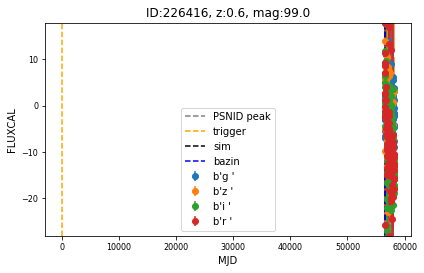

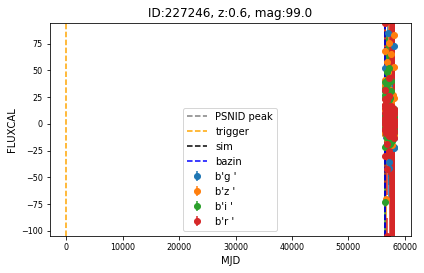

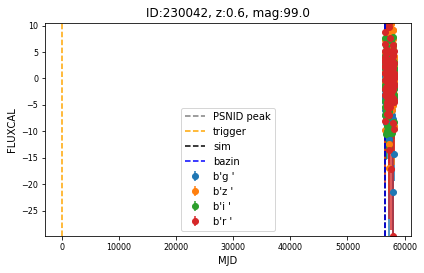

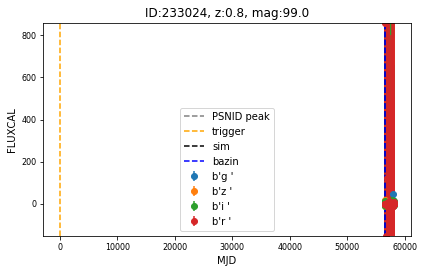

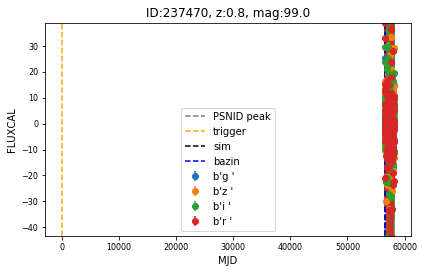

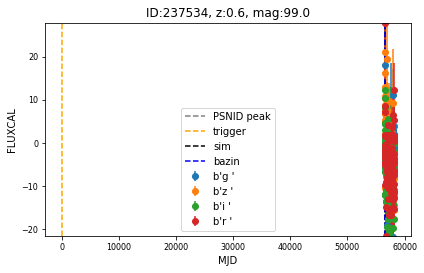

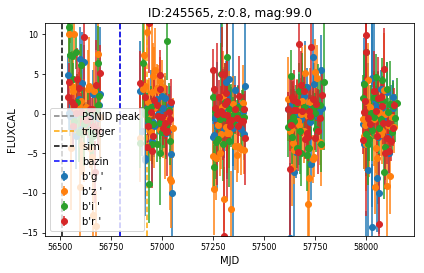

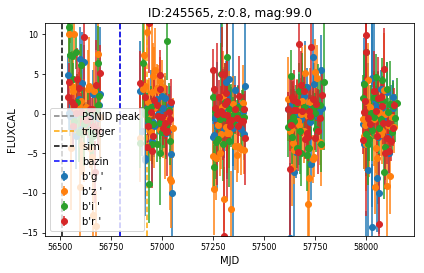

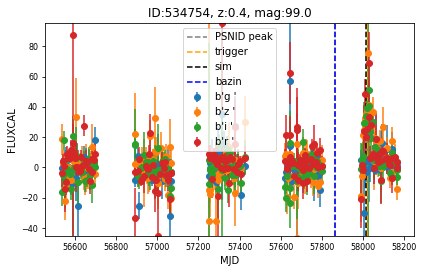

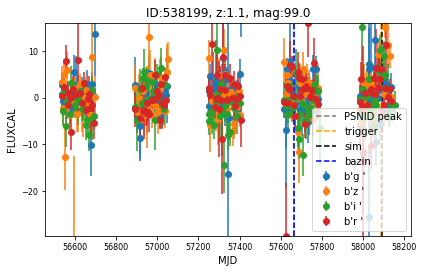

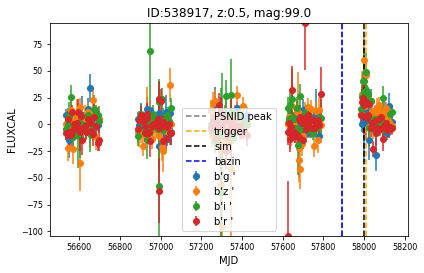

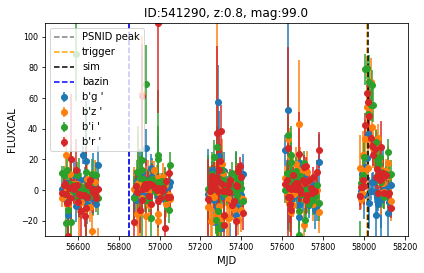

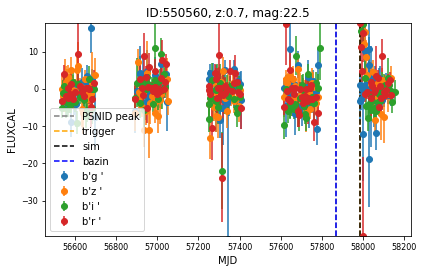

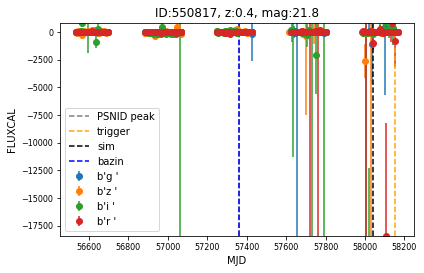

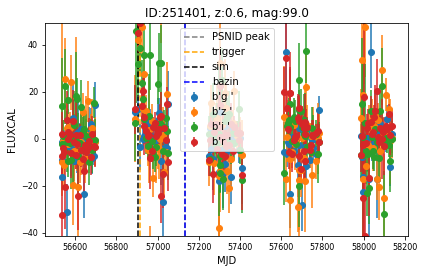

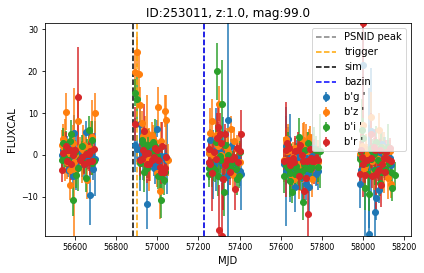

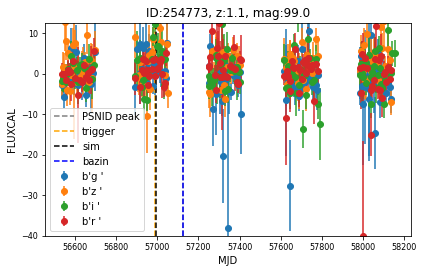

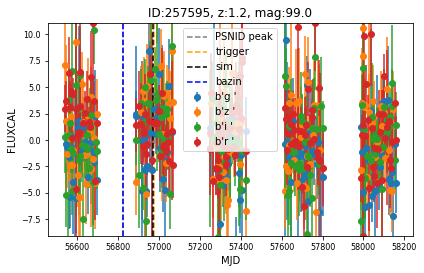

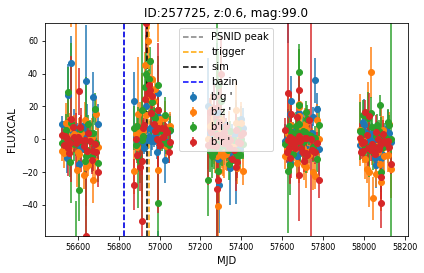

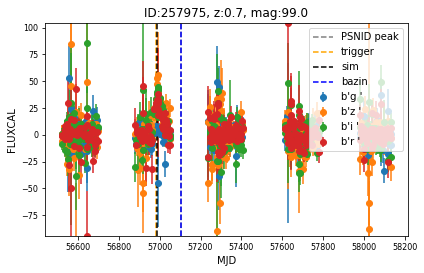

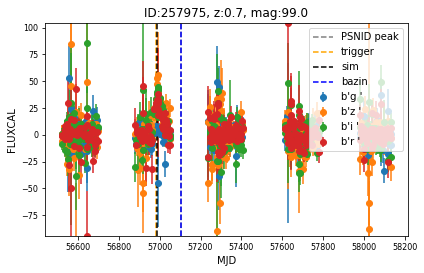

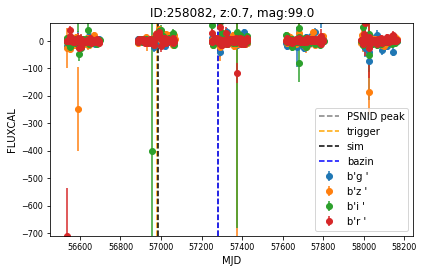

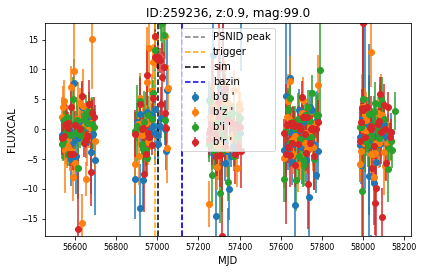

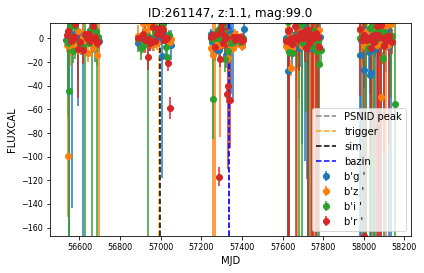

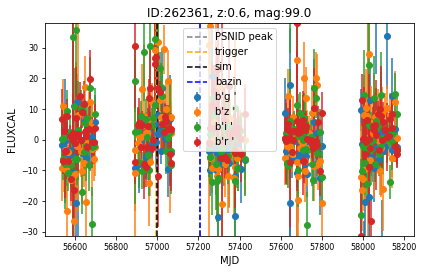

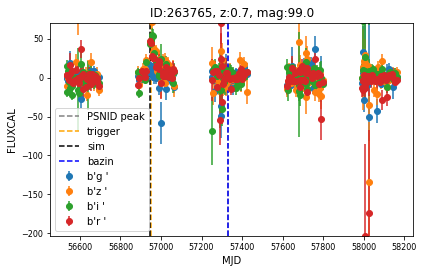

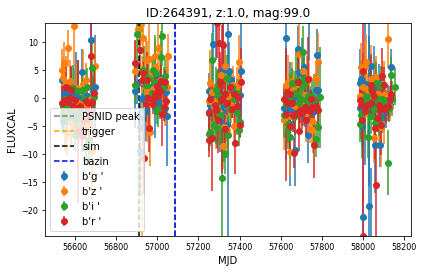

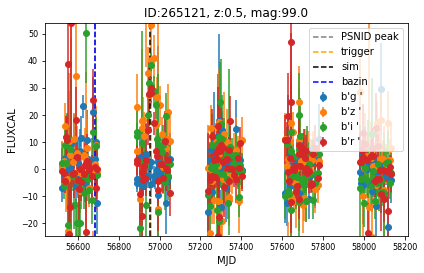

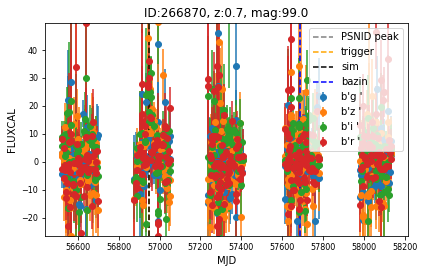

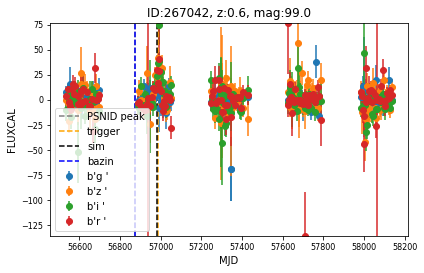

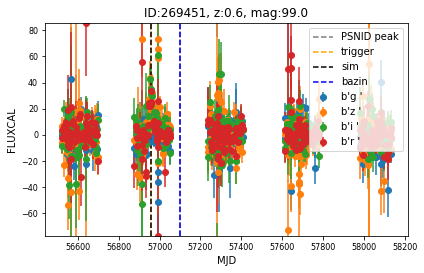

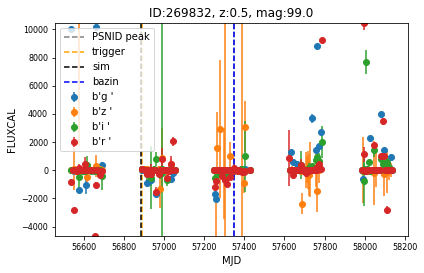

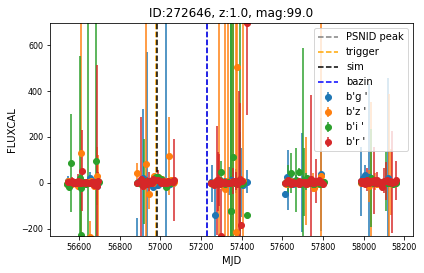

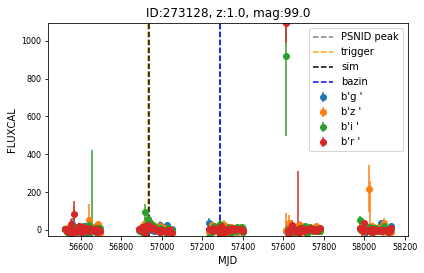

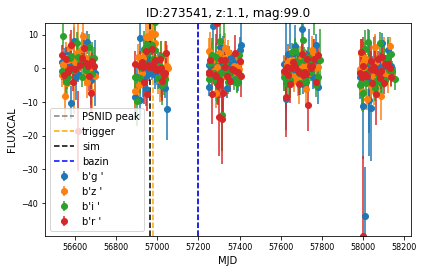

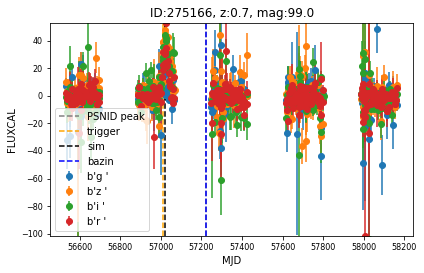

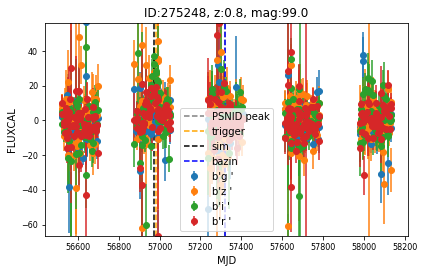

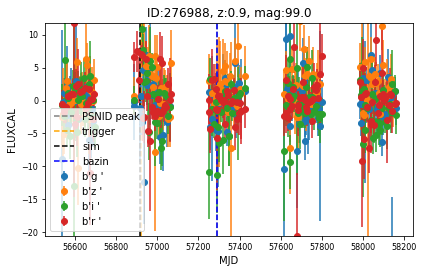

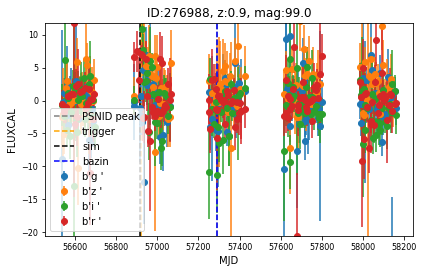

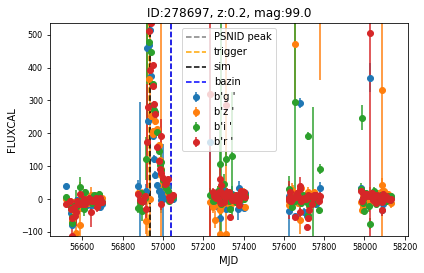

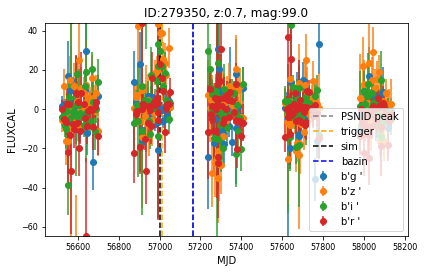

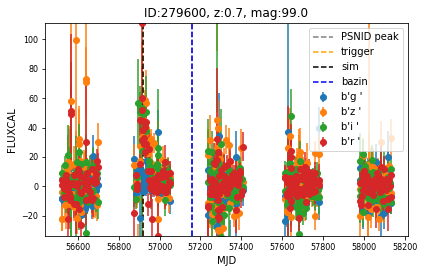

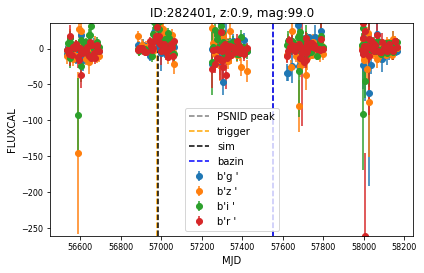

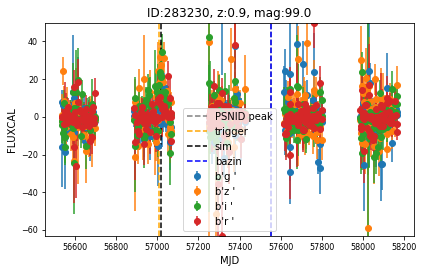

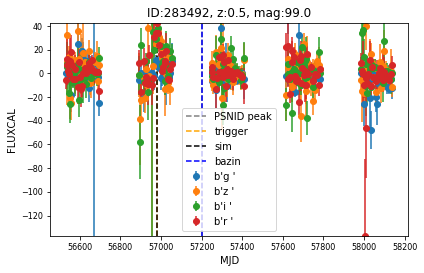

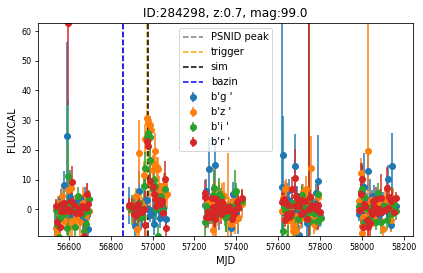

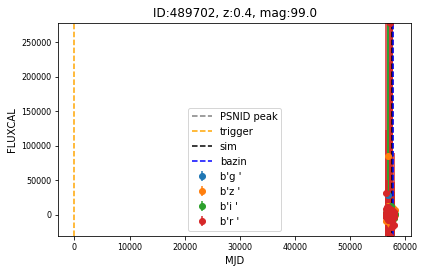

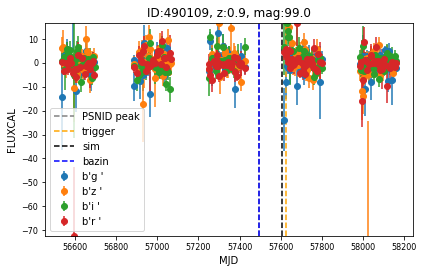

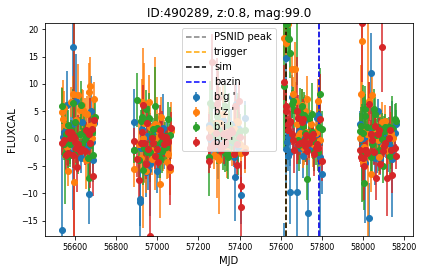

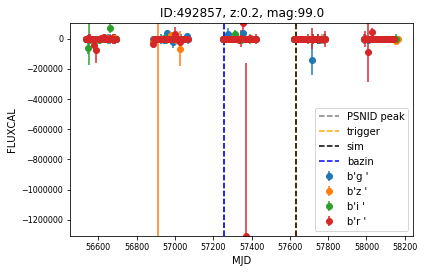

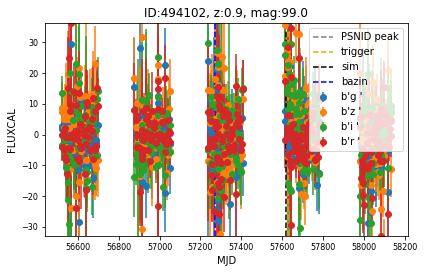

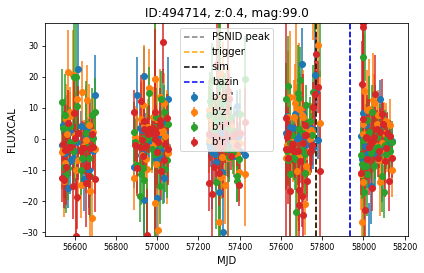

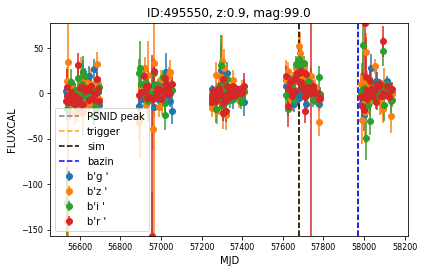

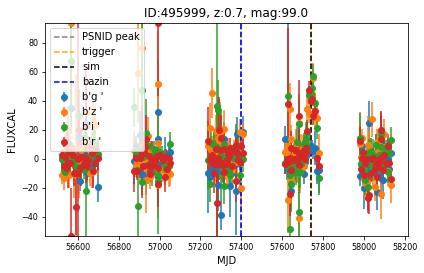

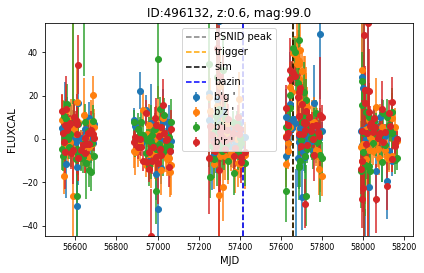

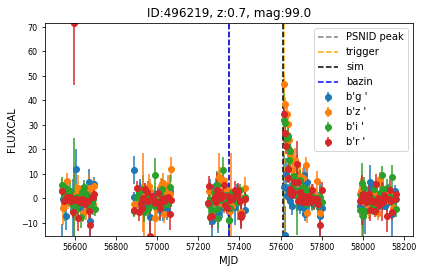

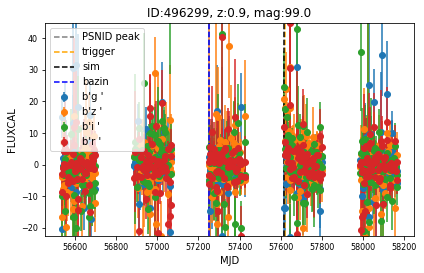

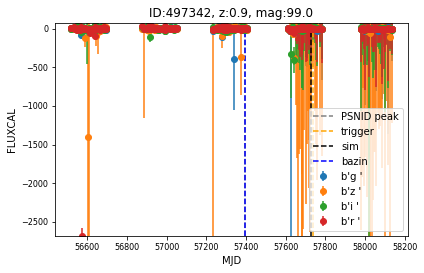

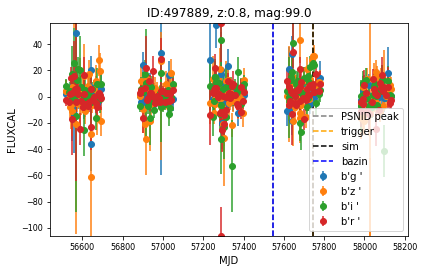

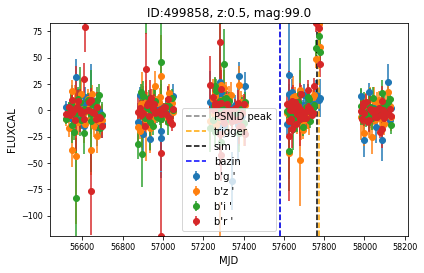

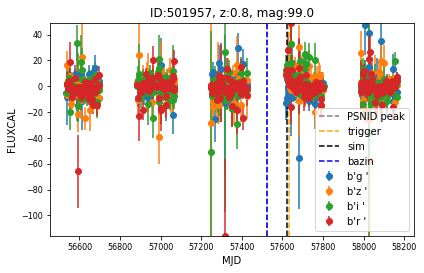

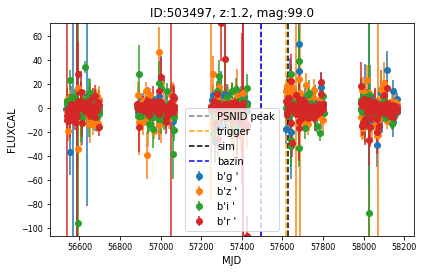

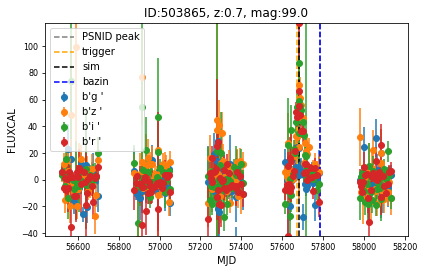

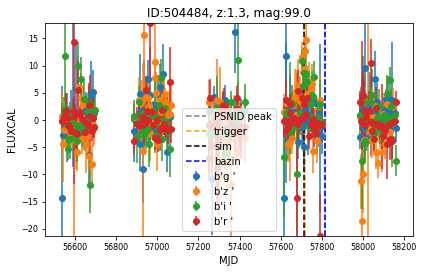

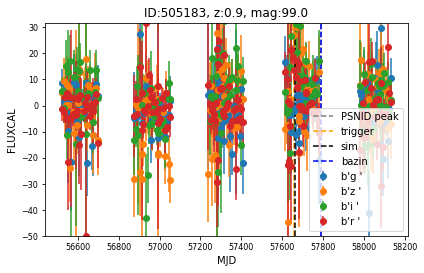

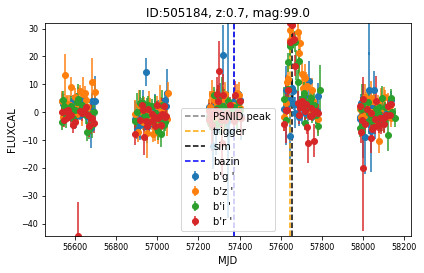

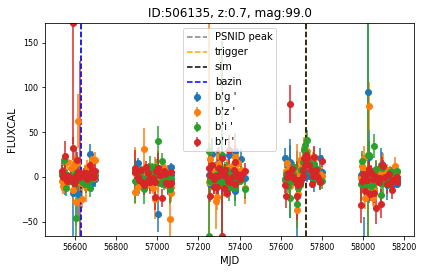

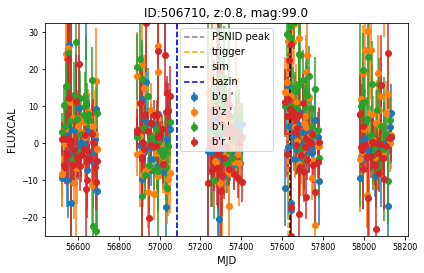

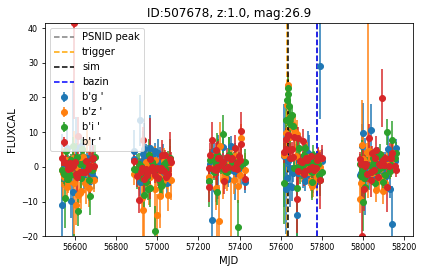

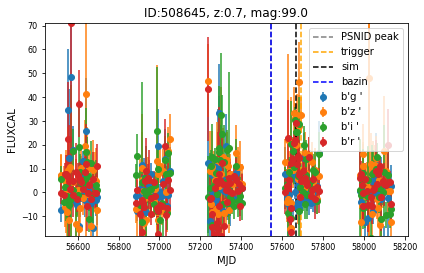

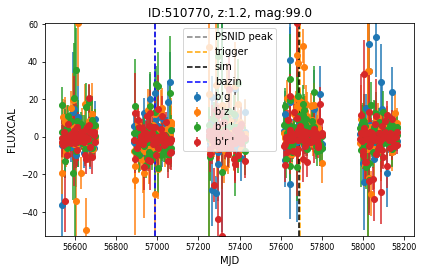

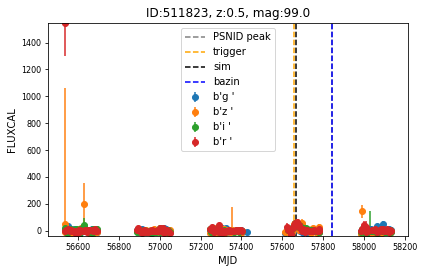

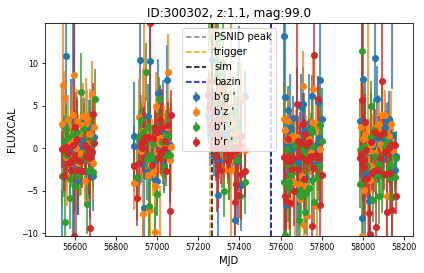

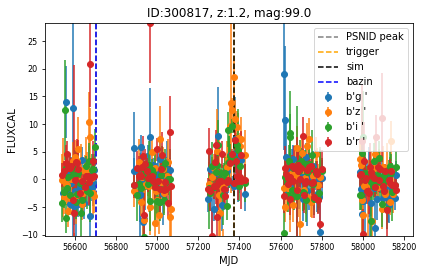

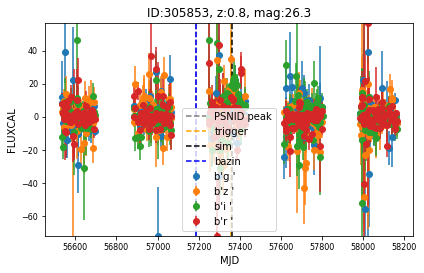

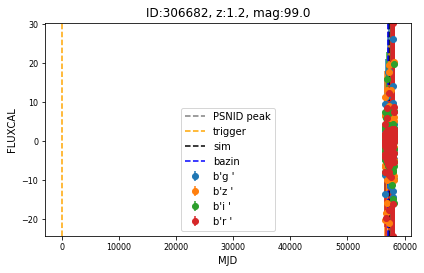

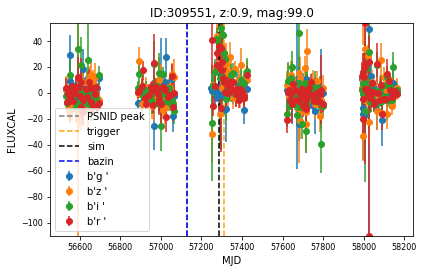

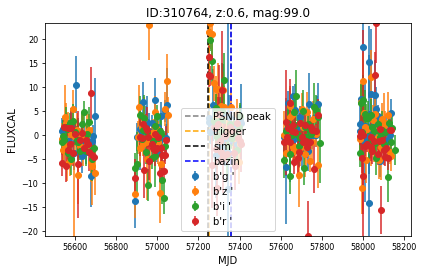

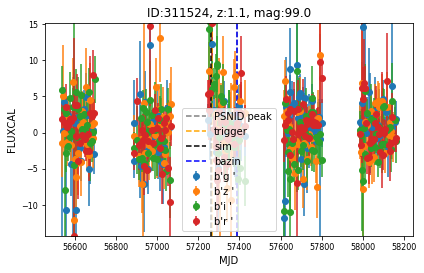

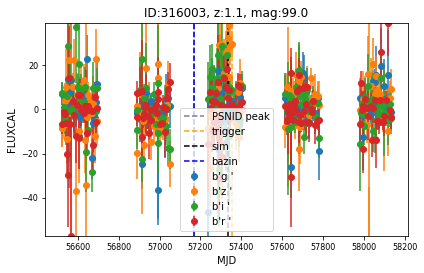

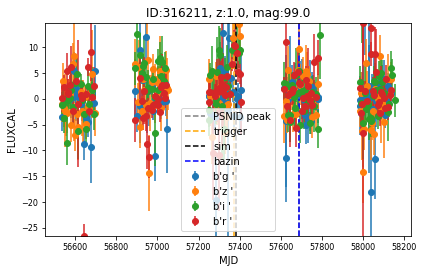

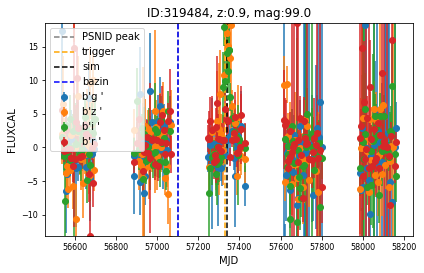

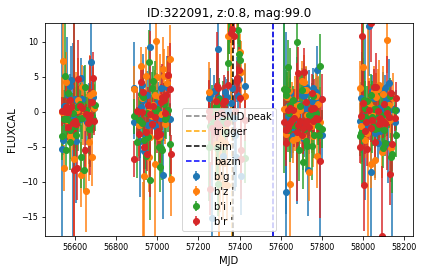

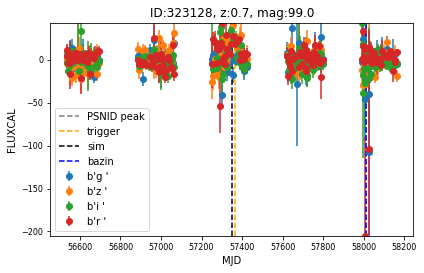

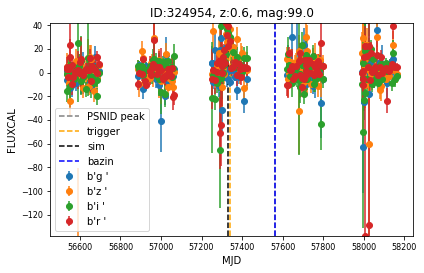

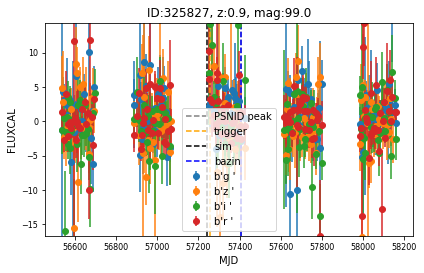

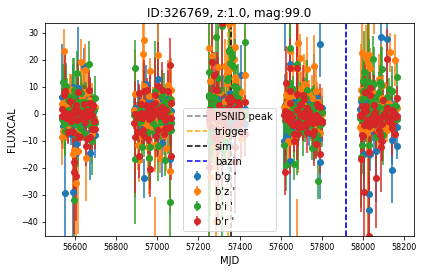

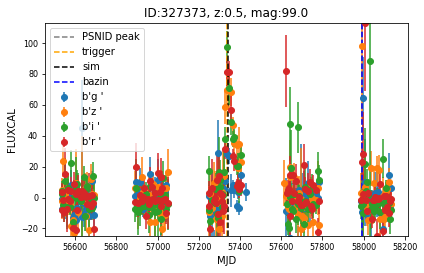

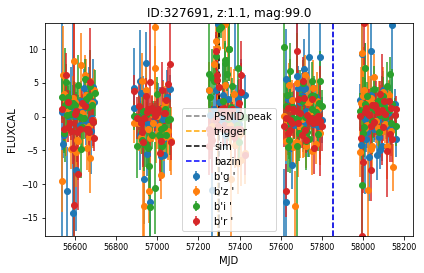

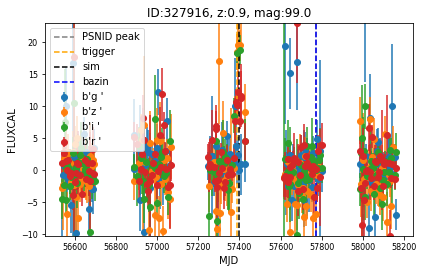

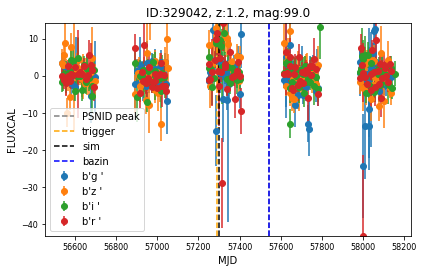

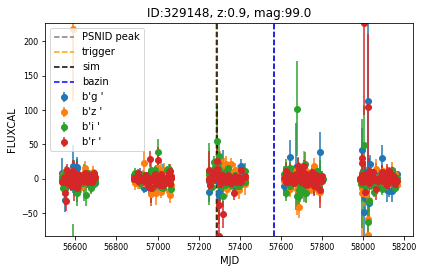

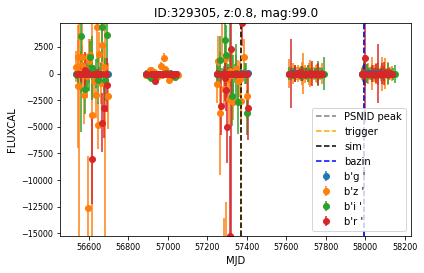

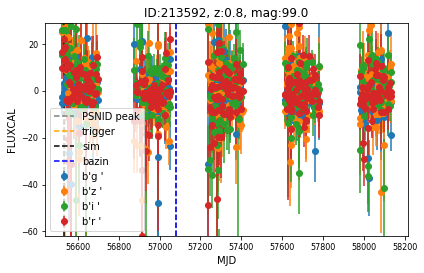

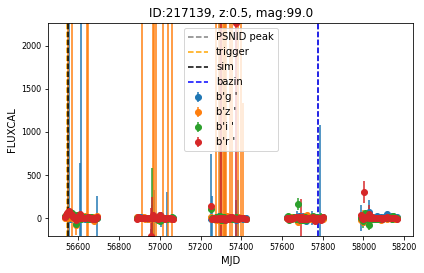

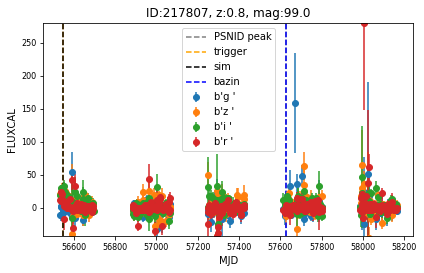

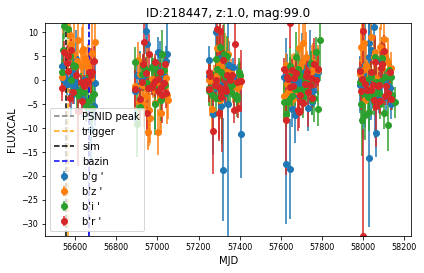

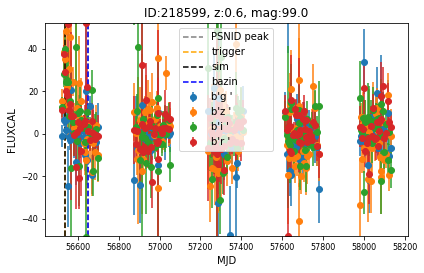

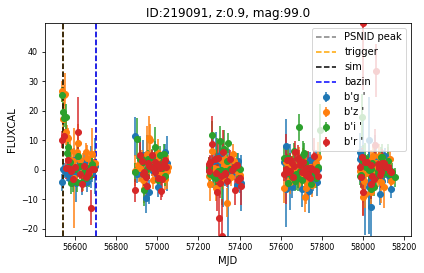

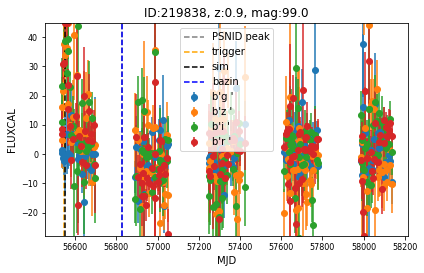

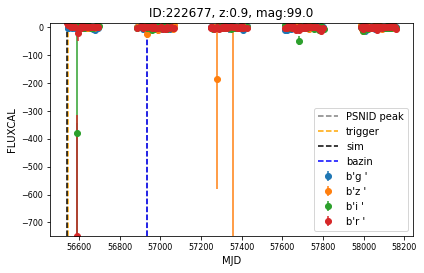

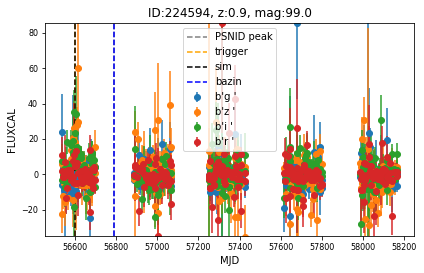

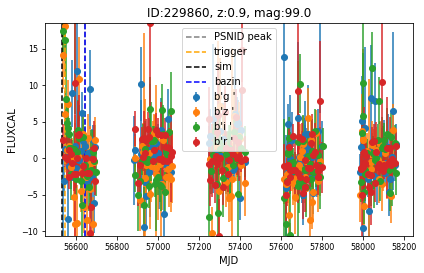

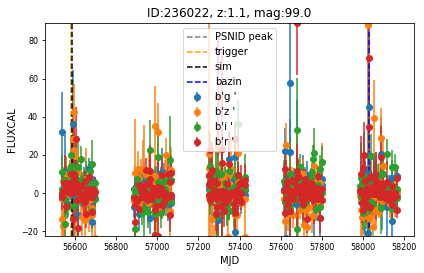

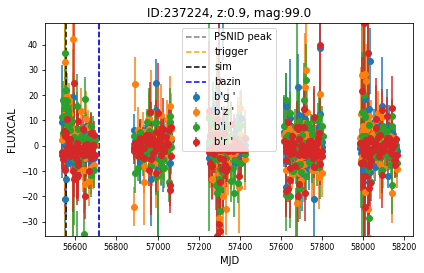

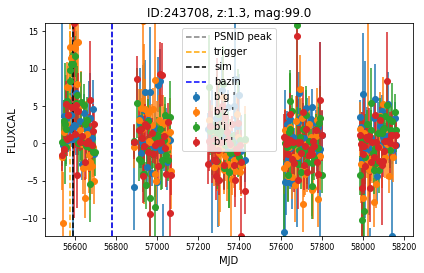

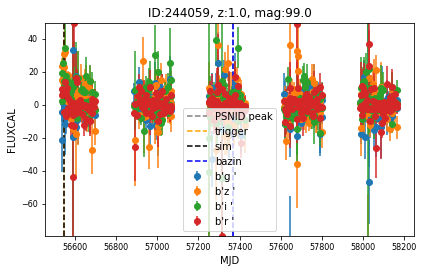

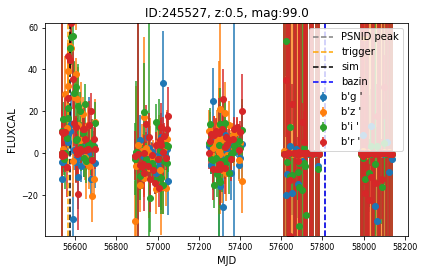

In [14]:
vu.plot_random_lcs(df_wp_fail_trigger, '../dumps/fail_trigger/', multiplots=False, nb_lcs=100, plot_peak=True)
vu.plot_random_lcs(df_wp_fail_bazin, '../dumps/fail_bazin/', multiplots=False, nb_lcs=100, plot_peak=True)